In [1]:
import pandas as pd
import numpy as np
import os

print(os.getcwd())
df = pd.read_csv('../output/df_general.csv',sep=',')
df = df.dropna()
y = df['stalling_event'].values
df = df.drop(['No.', 'Time','Protocol','ip_len','tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg',
       'tcp_flag_psh', 'tcp_flag_rst', 'prebuffering'],axis=1)
print(df.shape)
print(df.columns)
df = df.astype('float32')
X = df.values
print(X.dtype)

y = (y==1).astype(int)


C:\Users\Usuario\PycharmProjects\StallingEvents\codes
(1539774, 10)
Index(['∆t', 'pkt_len', 'tcp_hea_len', 'tcp_flag_ack', 'tcp_flag_syn',
       'tcp_flag_fin', 'tcp_win_si2', 'delay', 'capture', 'stalling_event'],
      dtype='object')
float32


Text(0.5, 1.0, 'Number of observations per class')

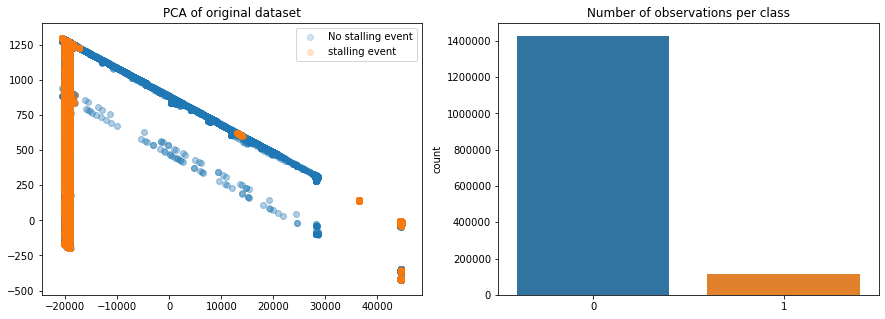

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dataset to 2 feature dimensions in order to visualize the data
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="No stalling event",alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="stalling event", alpha=0.2)
ax[0].set_title('PCA of original dataset')
ax[0].legend()

ax[1] = sns.countplot(y)
ax[1].set_title('Number of observations per class')

In [3]:
from sklearn import metrics 
from collections import Counter

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours

def model_resampling_pipeline(X_train, X_test, y_train, y_test, model):
    results = {'ordinary': {},
               'class_weight': {},
               'oversample': {},
               'undersample': {}}
    
    # ------ No balancing ------
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    
    results['ordinary'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                          'fscore': fscore, 'n_occurences': support,
                          'predictions_count': Counter(predictions),
                          'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                          'auc': auc}
    
    
    # ------ Class weight ------
    if 'class_weight' in model.get_params().keys():
        model.set_params(class_weight='balanced')
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['class_weight'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                  'fscore': fscore, 'n_occurences': support,
                                  'predictions_count': Counter(predictions),
                                  'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                  'auc': auc}

    
    # ------------ OVERSAMPLING TECHNIQUES ------------
    print('------ Oversampling methods ------')
    techniques = [RandomOverSampler(),
                  SMOTE(),
                  ADASYN()]
    
    for sampler in techniques:
        technique = sampler.__class__.__name__
        print(f'Technique: {technique}')
        print(f'Before resampling: {sorted(Counter(y_train).items())}')
        X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
        print(f'After resampling: {sorted(Counter(y_resampled).items())}')

        model.fit(X_resampled, y_resampled)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['oversample'][technique] = {'accuracy': accuracy, 
                                            'precision': precision, 
                                            'recall': recall,
                                            'fscore': fscore, 
                                            'n_occurences': support,
                                            'predictions_count': Counter(predictions),
                                            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                            'auc': auc}

    
    # ------------ UNDERSAMPLING TECHNIQUES ------------
    print('------ Undersampling methods ------')
    techniques = [RandomUnderSampler(),
                  NearMiss(version=1),
                  NearMiss(version=2),
                  TomekLinks(),
                  EditedNearestNeighbours()]
    
    for sampler in techniques:
        technique = sampler.__class__.__name__
        if technique == 'NearMiss': technique+=str(sampler.version)
        print(f'Technique: {technique}')
        print(f'Before resampling: {sorted(Counter(y_train).items())}')
        X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
        print(f'After resampling: {sorted(Counter(y_resampled).items())}')

        model.fit(X_resampled, y_resampled)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['undersample'][technique] = {'accuracy': accuracy, 
                                            'precision': precision, 
                                            'recall': recall,
                                            'fscore': fscore, 
                                            'n_occurences': support,
                                            'predictions_count': Counter(predictions),
                                            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                            'auc': auc}
        

    return results

Using TensorFlow backend.


In [4]:
def evaluate_method(results, method, metrics = ['precision', 'recall', 'fscore']):
    fig, ax = plt.subplots(1, 7, sharey=True, figsize=(16, 6))
    
    for i, metric in enumerate(metrics):
        ax[i*2].axhline(results['ordinary'][metric][0], label='No Resampling')
        ax[i*2+1].axhline(results['ordinary'][metric][1], label='No Resampling')
        
        if results['class_weight']:
            ax[i*2].bar(0, results['class_weight'][metric][0], label='Adjust Class Weight')
            ax[i*2+1].bar(0, results['class_weight'][metric][1], label='Adjust Class Weight')
            
        ax[0].legend(loc='upper center', bbox_to_anchor=(9, 1.01),
                     ncol=1, fancybox=True, shadow=True)
        
        for j, (technique, result) in enumerate(results[method].items()):
            ax[i*2].bar(j+1, result[metric][0], label=technique)
            
            ax[i*2+1].bar(j+1, result[metric][1], label=technique)
        
        
        ax[i*2].set_title(f'Low quality wine: \n{metric}')
        ax[i*2+1].set_title(f'High quality wine: \n{metric}')
    
    # AUC vis
    ax[6].set_title(f'Area under curve')
    ax[6].axhline(results['ordinary']['auc'], label='No Resampling')
    if results['class_weight']:
        ax[6].bar(0, results['class_weight']['auc'], label='Adjust Class Weight')
    for j, (technique, result) in enumerate(results[method].items()):
        ax[6].bar(j+1, result['auc'], label=technique)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

print(X_train.dtype)
X_train = np.float32(X_train)
X_test = np.float32(X_test)
y_train = np.float32(y_train)
y_test = np.float32(y_test)
print(X_train.dtype)
print(X_test.dtype)
print(y_train.dtype)
print(y_test.dtype)

float32
float32
float32
float32
float32


In [7]:
'''
model = DecisionTreeClassifier(max_depth=4,random_state=42)
model.fit(X_train, y_train)

from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot  
from sklearn import tree

dot_data = StringIO()  
tree.export_graphviz(model, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#Image(graph[0].create_png())'''

'\nmodel = DecisionTreeClassifier(max_depth=4,random_state=42)\nmodel.fit(X_train, y_train)\n\nfrom IPython.display import Image  \nfrom sklearn.externals.six import StringIO  \nimport pydot  \nfrom sklearn import tree\n\ndot_data = StringIO()  \ntree.export_graphviz(model, out_file=dot_data)\ngraph = pydot.graph_from_dot_data(dot_data.getvalue())  \n#Image(graph[0].create_png())'

In [8]:
model = DecisionTreeClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0.0, 1127136), (1.0, 104683)]
After resampling: [(0.0, 1127136), (1.0, 1127136)]
Technique: SMOTE
Before resampling: [(0.0, 1127136), (1.0, 104683)]
After resampling: [(0.0, 1127136), (1.0, 1127136)]
Technique: ADASYN
Before resampling: [(0.0, 1127136), (1.0, 104683)]
After resampling: [(0.0, 1127136), (1.0, 1127246)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0.0, 1127136), (1.0, 104683)]
After resampling: [(0.0, 104683), (1.0, 104683)]
Technique: NearMiss1
Before resampling: [(0.0, 1127136), (1.0, 104683)]
After resampling: [(0.0, 104683), (1.0, 104683)]
Technique: NearMiss2
Before resampling: [(0.0, 1127136), (1.0, 104683)]


MemoryError: Unable to allocate array with shape (1127136, 104683) and data type float64

In [ ]:
evaluate_method(results, 'oversample')

In [ ]:
evaluate_method(results, 'undersample')

In [ ]:
model = RandomForestClassifier(max_depth=2,n_jobs=-1,verbose=1,warm_start=True,random_state=42)
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

In [ ]:
evaluate_method(results, 'oversample')

In [ ]:
evaluate_method(results, 'undersample')

In [ ]:
model = LogisticRegression(random_state=42,C=0.1,max_iter=300,verbose=1,n_jobs=-1,warm_start=True)
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

In [ ]:
evaluate_method(results, 'oversample')

In [ ]:
evaluate_method(results, 'undersample')

In [ ]:
model = SVC(random_state=42,C=0.1,verbose=True)
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

In [ ]:
evaluate_method(results, 'oversample')

In [ ]:
evaluate_method(results, 'undersample')

In [ ]:
model = KNeighborsClassifier(n_neighbors=20,n_jobs=-1)
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

In [ ]:
evaluate_method(results, 'oversample')

In [ ]:
evaluate_method(results, 'undersample')

In [ ]:
model = AdaBoostClassifier(random_state=42,n_estimators=20,learning_rate=0.1)
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

In [ ]:
evaluate_method(results, 'oversample')

In [ ]:
evaluate_method(results, 'undersample')

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='lbfgs',max_iter=300,random_state=42,verbose=True,learning_rate=0.1)
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

In [ ]:
evaluate_method(results, 'oversample')

In [ ]:
evaluate_method(results, 'undersample')